# Tutorial: water monitoring data (WL, TDS)

This tutorial covers water level and salinity monitoring data

We will download the relevant data using this package (python-sa-gwdata) -- importable as ``sa_gwdata`` -- and use some other packages for other things:

- matplotlib, numpy, pandas - used in the background

In [72]:
import sa_gwdata

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
# import contextily as cx

## Water level data

I'll assume that you have already worked out which well you want to download data for - please see previous tutorials for how to find wells. We're going to look at data from a monitoring well near Port Lincoln: 6028-536 (also known as obswell FLN029).

First we need to make sure we have correctly identified the well, and obtain its drillhole number:

In [73]:
wells = sa_gwdata.find_wells("6028-536")

In [74]:
wells

['FLN029']

In [75]:
df = sa_gwdata.water_levels(wells)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dh_no            561 non-null    int64         
 1   network          561 non-null    object        
 2   unit_long        561 non-null    int64         
 3   aquifer          561 non-null    object        
 4   easting          561 non-null    float64       
 5   northing         561 non-null    float64       
 6   zone             561 non-null    int64         
 7   unit_hyphen      561 non-null    object        
 8   obs_no           561 non-null    object        
 9   obs_date         561 non-null    datetime64[ns]
 10  dtw              560 non-null    float64       
 11  swl              560 non-null    float64       
 12  rswl             560 non-null    float64       
 13  pressure         0 non-null      float64       
 14  temperature      0 non-null      float64  

In [76]:
df[['obs_date', 'dtw', 'swl', 'rswl', 'anomalous_ind', 'comments']]

,obs_date,dtw,swl,rswl,anomalous_ind,comments
0,1959-02-26,10.67,10.67,1.67,N,NaN
1,1960-02-11,10.76,10.76,1.58,N,NaN
2,1964-11-04,10.70,10.70,1.64,N,NaN
3,1965-10-06,10.96,10.96,1.38,N,NaN
4,1966-01-06,11.01,11.01,1.33,N,NaN
...,...,...,...,...,...,...
556,2020-03-17,12.83,12.25,0.09,N,NaN
557,2020-10-11,12.80,12.22,0.12,N,NaN
558,2021-03-20,12.89,12.31,0.03,N,NaN
559,2021-10-26,12.87,12.29,0.05,N,NaN


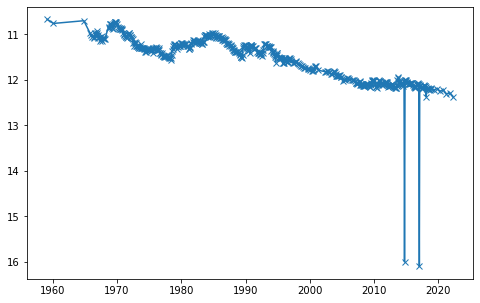

In [77]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.plot(df.obs_date, df.swl, marker='x')
ax.invert_yaxis()

### Anomalous data points

Note the three outliers. These have actually been flagged as anomalous:

In [78]:
df[df.obs_date.dt.year == 2014][['obs_date', 'dtw', 'swl', 'rswl', 'anomalous_ind', 'comments']]

,obs_date,dtw,swl,rswl,anomalous_ind,comments
493,2014-01-13,12.61,12.03,0.31,N,NaN
494,2014-02-10,12.64,12.06,0.28,N,NaN
495,2014-03-11,12.67,12.09,0.25,N,NaN
496,2014-04-09,12.68,12.10,0.24,N,NaN
497,2014-05-04,12.70,12.12,0.22,N,NaN
498,2014-05-05,12.70,12.12,0.22,N,NaN
499,2014-06-04,12.71,12.13,0.21,N,NaN
500,2014-07-28,12.61,12.03,0.31,N,NaN
501,2014-08-25,12.60,12.02,0.32,N,NaN
502,2014-09-22,16.58,16.00,-3.66,Y,Transcription error


And if you want, you can opt to always exclude "anomalous" readings, although it is should be noted the definition of "anomalous" is somewhat subjective:

In [79]:
df = sa_gwdata.water_levels(wells, anomalous=False)
df[df.obs_date.dt.year == 2014][['obs_date', 'dtw', 'swl', 'rswl', 'anomalous_ind', 'comments']]

,obs_date,dtw,swl,rswl,anomalous_ind,comments
493,2014-01-13,12.61,12.03,0.31,N,NaN
494,2014-02-10,12.64,12.06,0.28,N,NaN
495,2014-03-11,12.67,12.09,0.25,N,NaN
496,2014-04-09,12.68,12.10,0.24,N,NaN
497,2014-05-04,12.70,12.12,0.22,N,NaN
498,2014-05-05,12.70,12.12,0.22,N,NaN
499,2014-06-04,12.71,12.13,0.21,N,NaN
500,2014-07-28,12.61,12.03,0.31,N,NaN
501,2014-08-25,12.60,12.02,0.32,N,NaN
502,2014-10-22,12.59,12.01,0.33,N,NaN


### Groundwater level parameters

There are three different water level parameters:
    
1. **dtw (Depth To Water)**: this is in metres measured below a reference point. So increasing numbers indicate an increasing depth to water. Negative numbers indicate flowing artesian conditions. The reference point's true elevation above ground surface *can* change i.e. if a casing standpipe is chopped off or installed, so although this number is what is in effect measured in the real world, it should not be used for analysis. 
2. **swl (Standing Water Level)**: this is the Depth To Water, automatically corrected such that it represents a depth below ground level, which should be constant in terms of its real-world elevation, except in very rare cases. Note that the property is the same as DTW, in the sense that as the number increases, the depth to groundwater is increasing. Negative numbers indicate flowing artesian conditions.
3. **rswl (Reduced Standing Water Level)**: this value has been corrected to represent the groundwater level measured above Australian Height Datum (AHD). This means that as the number increases, the depth to groundwater is *decreasing* i.e. the groundwater elevation is increasing. Positive/negative numbers relate to the groundwater level compared to mean sea level, not the local ground elevation.

RSWL values are only present when we have an elevation survey for that well (sometimes it will be derived from a digital elevation model and not a physical survey - care should obviously be taken with those). See the elevation tutorial - TODO.

Note that there is no distinguishing between physical groundwater levels (i.e. the water table) and water levels as measured in a well which penetrates and provides access to a confined aquifer (i.e. a groundwater pressure level). Even wells which access confined groundwater with flowing artesian conditions, where the pressure level is measured using a pressure gauge at surface, have data reported using this method as "Depth to Water" (which would in that case be a negative number).

To compare all of these parameters, see them on a chart:

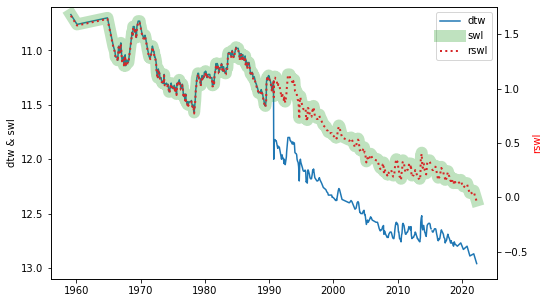

In [80]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(df.obs_date, df.dtw, label='dtw', color='tab:blue')
ax.plot(df.obs_date, df.swl, label='swl', color='tab:green', lw=12, alpha=0.3)
ax.plot([], [], label='rswl', color='tab:red', alpha=1, lw=2, ls=':')
ax.invert_yaxis()
span = 2.5
ax_top = 10.6
ax2_top = 1.75
ax.set_ylim(ax_top + span, ax_top)
ax.set_ylabel('dtw & swl', color='black')
ax2 = ax.twinx()
ax2.plot(df.obs_date, df.rswl, label='rswl', color='tab:red', alpha=1, lw=2, ls=':')
ax2.set_ylim(ax2_top - span, ax2_top)
ax2.set_ylabel('rswl', color='red')
ax.legend()

Note the change in casing reference point around 1990 - clearly a casing standpipe was installed, because overnight, the depth to water increased by about one metre, and the new measurements were being made from the top of the standpipe, instead of ground level.

### Measured during!

There is a metadata property attached to water level and salinity data called "measured during". This indicates what kind of activity the data was obtained during, and it is a good way to filter out irrelevant measurements from relevant ones in terms of monitoring.

These are the values that measured_during can take:

In [137]:
meas_during_lut = {
    'A': 'Aquifer Test',
    'D': 'Drilling',
    'F': 'Field Survey',
    'S': 'Final Sample on drilling completion',
    'G': 'Geophysical Logging',
    'L': 'Landowner Sample',
    'M': 'Monitoring',
    'R': 'Rehabilitation',
    'U': 'Unknown',
    'W': 'Well Yield',
}

An example is from well 6628-5103

In [134]:
wells = sa_gwdata.find_wells('6628-5103')

In [135]:
df = sa_gwdata.water_levels(wells)

In [136]:
df.measured_during.value_counts()

M    142
A      3
Name: measured_during, dtype: int64

Text(0, 0.5, 'swl')

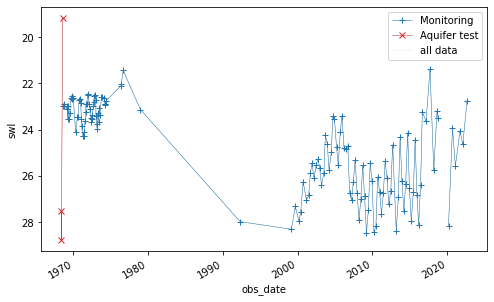

In [144]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
df[df.measured_during == 'M'].plot(ax=ax, x='obs_date', y='swl', color='tab:blue', marker='+', lw=0.5, label='Monitoring')
df[df.measured_during == 'A'].plot(ax=ax, x='obs_date', y='swl', color='tab:red', marker='x', lw=0.5, label='Aquifer test')
df.plot(ax=ax, x='obs_date', y='swl', lw=0.1, color='grey', label='all data')
ax.legend()
ax.invert_yaxis()
ax.set_ylabel('swl')

As you can see, filtering to only retain measured during "M" (monitoring) is often a good idea for analysis of water level data.

## Salinity data

Salinity tends to be monitored from different wells than water level.

Let's look at LKW039, a well from the other side of Eyre Peninsula at Coffin Bay.

In [145]:
wells = sa_gwdata.find_wells("LKW 39")

In [146]:
wells

['LKW039']

In [147]:
df = sa_gwdata.salinities(wells)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dh_no            168 non-null    int64         
 1   network          168 non-null    object        
 2   aquifer          168 non-null    object        
 3   unit_hyphen      168 non-null    object        
 4   unit_long        168 non-null    int64         
 5   obs_no           168 non-null    object        
 6   collected_date   168 non-null    datetime64[ns]
 7   collected_time   7 non-null      object        
 8   tds              168 non-null    int64         
 9   ec               168 non-null    int64         
 10  ph               20 non-null     float64       
 11  sample_type      168 non-null    object        
 12  anomalous_ind    168 non-null    object        
 13  test_place       86 non-null     object        
 14  extract_method   165 non-null    object   

These are the important fields:

- **tds (Total Dissolved Solids in mg/L)**: almost always estimated from the EC measurement by a standard formula - TODO document
- **ec (Electrical Conductivity at 25 deg C in uS/cm)**: the electrical conductivity, corrected for temperature
- **Anomalous indicator Y/N**: as for water level above
- **Test Place**: location that the EC was measured: values include:
  - U = Unknown
  - F = During fieldwork
  - RP = Regency Park i.e. the water test room
- **Extraction Method**: how the water sample was obtained for testing.
- **Measured During**: see discussion above
- **Data Source**: where the data came from

In [149]:
df[['collected_date', 'tds', 'ec', 'anomalous_ind', 'test_place', 'extract_method', 'measured_during', 'data_source']]

,collected_date,tds,ec,anomalous_ind,test_place,extract_method,measured_during,data_source
0,1985-03-25,392,712,N,U,PUMP,W,DEWNR
1,1985-03-25,386,701,N,U,PUMP,W,DEWNR
2,1985-03-25,392,713,N,U,PUMP,W,DEWNR
3,1985-03-25,387,704,N,U,PUMP,W,DEWNR
4,1985-03-25,392,712,N,U,PUMP,W,DEWNR
...,...,...,...,...,...,...,...,...
163,2015-04-20,1049,1900,N,NaN,PUMP,M,DEWNR
164,2016-04-18,1077,1950,N,F,PUMP,M,DEWNR
165,2019-12-14,1127,2040,N,RP,PUMP,M,DEW
166,2020-10-18,1076,1948,N,RP,PUMP,M,DEW


A key field for salinity data is certainly the extraction method, and usually values like PUMP and AIRL (airlifting) are the main ones you should filter for:

In [173]:
df.extract_method.fillna("NA").value_counts()

BAIL    134
PUMP     31
NA        3
Name: extract_method, dtype: int64

Text(0, 0.5, 'tds')

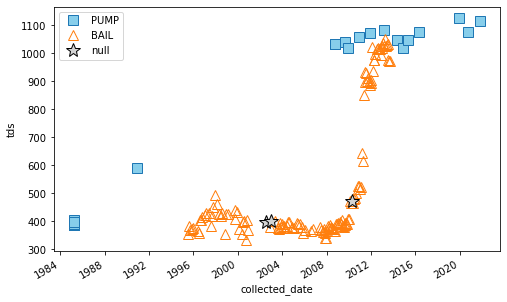

In [176]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
df[df.extract_method == 'PUMP'].plot(
    ax=ax, x='collected_date', y='tds', color='tab:blue', marker='s', ms=10, ls='none', label='PUMP', mfc='skyblue'
)
df[df.extract_method == 'BAIL'].plot(
    ax=ax, x='collected_date', y='tds', color='tab:orange', marker='^', ms=10, ls='none', label='BAIL', mfc='none'
)
df[pd.isnull(df.extract_method)].plot(
    ax=ax, x='collected_date', y='tds', color='black', marker='*', ms=15, ls='none', label='null', mfc='lightgrey'
)
ax.legend()
ax.set_ylabel('tds')